- Team Notion url : 
https://www.notion.so/831dba3b320a45dcb2acb570c251bac6

# Preprocess the raw_data

In [2]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir)

%matplotlib inline
%cd drive/MyDrive/데이콘_서울시민데이터_경진대회

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import os
import os.path as osp
from pathlib import Path

Mounted at /content/drive/
/content/drive/MyDrive/데이콘_서울시민데이터_경진대회


In [1]:
# 실제 25개 지역구 중에서 2개(종로구,동작구) 누락됨 -> 총 23개 지역구
district_list = list([
'강남구',
'강동구',
'강북구',
'강서구',
'관악구',
'광진구',
'구로구',
'금천구',
'노원구',
'도봉구',
'동대문구',
'마포구',
'서대문구',
'서초구',
'성동구',
'성북구',
'송파구',
'양천구',
'영등포구',
'용산구',
'은평구',
'중구',
'중랑구'])

for i, district in enumerate(district_list):
  print(i, district)

district_set = set(district_list)

0 강남구
1 강동구
2 강북구
3 강서구
4 관악구
5 광진구
6 구로구
7 금천구
8 노원구
9 도봉구
10 동대문구
11 마포구
12 서대문구
13 서초구
14 성동구
15 성북구
16 송파구
17 양천구
18 영등포구
19 용산구
20 은평구
21 중구
22 중랑구


### exp1: 피해 총액으로 레이블링한 데이터셋 (23개 지역구)
- 기준 경계 금액: 1e4 / 1e5 / 1e6
- 년도: 1997 ~ 2020

In [ ]:
데이터셋/지역구_년도.txt
  e.g., 0_1997.txt
    -> 레이블, AWS, 지형(고정: 면적,산림,하천), 사회(고정: 맨홀,빗물받이)

In [ ]:
def get_label(budget):
  if budget < 1e4:
    return 0
  elif budget < 1e5:
    return 1
  elif budget < 1e6:
    return 2
  elif budget > 1e6:
    return 3
  else:
    raise

#1. Label
df_label = pd.read_excel("서울시 이재민 피해현황_220925.xlsx", sheet_name=None)
#2. AWS
df_aws = pd.read_csv("aws_edit/df_train_aws.csv").dropna().drop(columns=["Unnamed: 0"]).reset_index(drop=True)
#3. fixed text via district
df_area = pd.read_excel("raw_data/지역구면적.xlsx", usecols=["시군구", "합 계"], skiprows=[1,2])[1:26].reset_index(drop=True)

df_mount = pd.read_excel("raw_data/산림면적(소유별)(1996_2010,+2015).xlsx", sheet_name="데이터", usecols=["자치구별(2)", "소유별(1)", "2015"])
df_mount = df_mount[df_mount["소유별(1)"]=="합계"].drop(columns=["소유별(1)"]).reset_index(drop=True)

df_river = pd.read_csv("raw_data/서울시 하천개황 정보.csv", encoding="cp949", usecols=["하천명", "종점명"])
for i, line in enumerate(df_river["종점명"]):
  for word in line.split():
    if word in district_set:
      df_river.loc[i,"지역구"] = word
df_river = df_river.dropna().drop(columns=["종점명"]).reset_index(drop=True)

In [ ]:
os.makedirs("dataset/exp1", exist_ok=True)

# Use this loop to make the whole datasets
for i, district in enumerate(district_list):
  # [0] 피해 현황
  df = df_label[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
  df = df[df["년도"]>=1997]

  #[예외처리] district "중구"
  contain_word = "중구" if district=="중구" else district[:-1]
  # [1] 기상학적 요인
  df2 = df_aws[df_aws["지점명"].str.contains(contain_word)].reset_index(drop=True)

  fixed_txt = ""
  # [2] 지형학적 요인
  fixed_txt += "\t" + str(df_area[df_area["시군구"].str.contains(district)].squeeze()["합 계"]) # 지역구 면적
  fixed_txt += "\t" + str(df_mount[df_mount["자치구별(2)"].str.contains(district)].squeeze()["2015"]) # 지역구 산림 면적
  fixed_txt += "\t" + str(np.sum(df_river["지역구"].str.contains(district))) # 지역구 하천 개수
  # [3] 사회경제적 요인
  df3 = df_social[df_social["지역구"].str.contains(district)].squeeze().to_string(header=False, index=False).split("\n")
  fixed_txt += "\t" + df3[1] # 지역구 맨홀 개수
  fixed_txt += "\t" + df3[2] # 지역구 빗물받이 개수
  
  for index, row in df.iterrows():
    year = row["년도"]

    #[예외처리] df2에서 누락된 년도 제거
    if np.sum(df2["일시"]==year)==0: 
      break

    #print(f"dataset/exp1/{i}_{year}.txt")   

    text = ""
    #1. Label
    text += str(get_label(row["총액"]))

    #2. AWS
    seq_list = df2[df2["일시"]==year].squeeze().iloc[2:]
    for word in seq_list.to_string(header=False, index=False).split("\n"):
      word = word.strip()
      text += "\t" + word
    
    #3. fixed text via district
    text += fixed_txt

    # Save as TXT file
    with open(f"dataset/exp1/{i}_{year}.txt", "w") as f:
      f.write(text)

In [ ]:
path_dataset = "dataset/exp1"
osp.join(path_dataset, )
for filename in os.listdir(path_dataset):
  print(osp.join(path_dataset, filename))

In [ ]:
with open(f"dataset/exp1/{i}_{year}.txt", "r") as f:
  line = f.readlines()[0].split("\t")
  print(line)
  print(len(line))

['3', '1559.0', '17.322222', '45.244486', '301.0', '24.508889', '1.878889', '13.5', '33.9', '13.1', '357.1', '5.0', '18.4960823', '532.0', '2', '12106', '18496']
17


### exp2: [ 피해 총액 & 이재민 & 인명 ] 으로 레이블링한 데이터셋 (23개 지역구)
- 기준 경계 금액: 1e4 / 1e5 / 1e6
- 년도: 1997 ~ 2020

In [ ]:
데이터셋/지역구_년도.txt
  e.g., 0_1997.txt
    -> 레이블, AWS, 지형(고정: 면적,산림,하천), 사회(고정: 맨홀,빗물받이)

In [12]:
def get_label(budget, missing, passed):
  # budget: 피해 총액 (천원)
  # missing: 이재민 ~ 명당 백만원 (1000 천원)
  # passed: 인명 ~ 명당 삼천만원 (30000 천원)
  budget = budget + 1000*missing + 30000*passed
  if budget < 1e4:
    return 0
  elif budget < 1e5:
    return 1
  elif budget < 1e6:
    return 2
  elif budget > 1e6:
    return 3
  else:
    raise

#1. Label
df_label = pd.read_excel("서울시 이재민 피해현황_220925.xlsx", sheet_name=None)
#2. AWS
df_aws = pd.read_csv("aws_edit/df_train_aws.csv").dropna().drop(columns=["Unnamed: 0"]).reset_index(drop=True)
#3. fixed text via district
df_area = pd.read_excel("raw_data/지역구면적.xlsx", usecols=["시군구", "합 계"], skiprows=[1,2])[1:26].reset_index(drop=True)

df_mount = pd.read_excel("raw_data/산림면적(소유별)(1996_2010,+2015).xlsx", sheet_name="데이터", usecols=["자치구별(2)", "소유별(1)", "2015"])
df_mount = df_mount[df_mount["소유별(1)"]=="합계"].drop(columns=["소유별(1)"]).reset_index(drop=True)

df_river = pd.read_csv("raw_data/서울시 하천개황 정보.csv", encoding="cp949", usecols=["하천명", "종점명"])
for i, line in enumerate(df_river["종점명"]):
  for word in line.split():
    if word in district_set:
      df_river.loc[i,"지역구"] = word
df_river = df_river.dropna().drop(columns=["종점명"]).reset_index(drop=True)


#
df_social = pd.read_excel("data.xlsx", skiprows=[1]).reset_index(drop=True)


In [15]:
label_temp_list = []
os.makedirs("dataset/exp2", exist_ok=True)

# Use this loop to make the whole datasets
for i, district in enumerate(district_list):
  # [0] 피해 현황
  df = df_label[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
  df = df[df["년도"]>=1997]

  #[예외처리] district "중구"
  contain_word = "중구" if district=="중구" else district[:-1]
  # [1] 기상학적 요인
  df2 = df_aws[df_aws["지점명"].str.contains(contain_word)].reset_index(drop=True)

  fixed_txt = ""
  # [2] 지형학적 요인
  fixed_txt += "\t" + str(df_area[df_area["시군구"].str.contains(district)].squeeze()["합 계"]) # 지역구 면적
  fixed_txt += "\t" + str(df_mount[df_mount["자치구별(2)"].str.contains(district)].squeeze()["2015"]) # 지역구 산림 면적
  fixed_txt += "\t" + str(np.sum(df_river["지역구"].str.contains(district))) # 지역구 하천 개수
  # [3] 사회경제적 요인
  df3 = df_social[df_social["지역구"].str.contains(district)].squeeze().to_string(header=False, index=False).split("\n")
  fixed_txt += "\t" + df3[1] # 지역구 맨홀 개수
  fixed_txt += "\t" + df3[2] # 지역구 빗물받이 개수
  
  for index, row in df.iterrows():
    year = row["년도"]

    #[예외처리] df2에서 누락된 년도 제거
    if np.sum(df2["일시"]==year)==0: 
      break

    label_temp_list.append(get_label(row["총액"], row["이재민\n(명)"], row["인명\n(명)"]))
    
    text = ""
    #1. Label
    text += str(get_label(row["총액"], row["이재민\n(명)"], row["인명\n(명)"]))

    #2. AWS
    seq_list = df2[df2["일시"]==year].squeeze().iloc[2:]
    for word in seq_list.to_string(header=False, index=False).split("\n"):
      word = word.strip()
      text += "\t" + word
    
    #3. fixed text via district
    text += fixed_txt

    # Save as TXT file
    with open(f"dataset/exp2/{i}_{year}.txt", "w") as f:
      f.write(text)

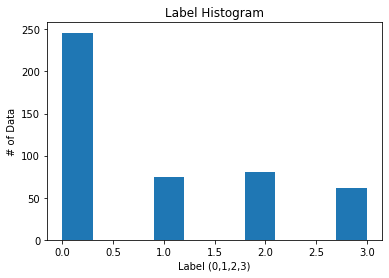

전체 데이터 개수 : 463

레이블 0인 데이터 개수 : 246
레이블 1인 데이터 개수 : 75
레이블 2인 데이터 개수 : 81
레이블 3인 데이터 개수 : 61


In [18]:
label_temp_list = np.array(label_temp_list)
plt.hist(label_temp_list)
plt.title("Label Histogram")
plt.xlabel("Label (0,1,2,3)")
plt.ylabel("# of Data")
plt.show()

print("전체 데이터 개수 :", len(label_temp_list))
print()
print("레이블 0인 데이터 개수 :", np.sum(label_temp_list==0))
print("레이블 1인 데이터 개수 :",np.sum(label_temp_list==1))
print("레이블 2인 데이터 개수 :", np.sum(label_temp_list==2))
print("레이블 3인 데이터 개수 :", np.sum(label_temp_list==3))

# 생략

## 서울시 주민등록인구 (2008~2021)

In [ ]:
use_cols = ["동별(2)"]
for i in range(2008, 2022):
  use_cols += [f"{i} {j}/4" for j in range(1,5)]

In [ ]:
df_raw = pd.read_excel("raw_data/서울시_주민등록인구_2008_2021.xlsx", sheet_name="데이터")
df_raw.head()

In [ ]:
df_raw = pd.read_excel("raw_data/서울시_주민등록인구_2008_2021.xlsx", sheet_name="데이터", usecols=use_cols, skiprows=[1,2])
df_raw.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,동별(2),2008 1/4,2008 2/4,2008 3/4,2008 4/4,2009 1/4,2009 2/4,2009 3/4,2009 4/4,2010 1/4,...,2019 3/4,2019 4/4,2020 1/4,2020 2/4,2020 3/4,2020 4/4,2021 1/4,2021 2/4,2021 3/4,2021 4/4
0,종로구,72934.0,73746.0,74471.0,74660.0,74609.0,74372.0,74472.0,74315.0,74300.0,...,73942.0,73947.0,74151.0,74497.0,74861.0,75003.0,74113.0,73525.0,73652.0,73494.0
1,중구,57662.0,58045.0,58288.0,58174.0,58161.0,58134.0,58184.0,58249.0,58472.0,...,62593.0,62739.0,63045.0,63354.0,63594.0,63686.0,63746.0,62897.0,63267.0,63519.0
2,용산구,105217.0,105612.0,106641.0,106966.0,107275.0,107226.0,107316.0,107456.0,107407.0,...,109911.0,110126.0,110895.0,111586.0,112451.0,113093.0,112881.0,111650.0,111177.0,111036.0
3,성동구,135438.0,133759.0,131725.0,128658.0,127584.0,126874.0,126915.0,126670.0,126942.0,...,136466.0,135838.0,135643.0,135937.0,136096.0,135870.0,135883.0,134542.0,134620.0,134233.0
4,광진구,154892.0,155265.0,155629.0,155676.0,156191.0,155949.0,155901.0,156140.0,156264.0,...,164173.0,164428.0,165287.0,166307.0,166857.0,167427.0,166638.0,166957.0,167438.0,167949.0


## 서울시 수해대피소 공간정보

In [ ]:
df_raw2 = pd.read_csv("raw_data/서울시_수해대피소_공간정보.csv", encoding="cp949", usecols=["대피소 명칭", "수용가능최대인원", "행정동 명칭"])
df_raw2.head()

,대피소 명칭,수용가능최대인원,행정동 명칭
0,인왕중학교,30,홍제3동
1,서울신방학초등학교,2537,방학3동
2,인창중학교,450,충현동
3,대치4문화센터,950,대치4동
4,교동초등학교,1400,종로1.2.3.4가동


## 서울시 하천 수위 현황 (실시간이라 사용 불가)

In [ ]:
pd.read_csv("raw_data/서울시_하천_수위_현황.csv", encoding="cp949").head()

,수위계코드,수위계명,하천명,구청코드,구청명,송신지 자료수집 시각,수신서버 저장 시각,실시간 하천 수위값(m),제방고(m),계획홍수위(m),하상고(m),통제수위(m)
0,101,여수대교,탄천,101,강남구,2022-09-22 19:26:10,2022-09-22 19:26:38,15.54,25.17,24.25,15.20,22.67
1,102,대곡교,탄천,101,강남구,2022-09-22 19:26:10,2022-09-22 19:26:38,11.73,20.09,18.01,10.76,0.00
2,103,탄천2교,탄천,101,강남구,2022-09-22 19:24:11,2022-09-22 19:26:38,5.96,21.43,18.01,4.41,0.00
3,301,모래말옆,방학천,103,도봉구,2022-09-22 19:26:10,2022-09-22 19:26:38,21.31,24.63,23.89,20.95,0.00
4,302,노원교,중랑천,103,도봉구,2022-09-22 19:26:11,2022-09-22 19:26:38,21.76,30.92,28.43,21.44,0.00


# Label: 지역구 이재민 피해 현황 (년 단위)
- 1971 ~ 2020
- 지역구별로 누락된 년도가 제각각임
- 따라서 본 피해 현황 년도를 기준으로 데이터셋을 구성해야 한다.

### read excel

In [5]:
# df_raw는 지역구별로 sheet가 존재하기 때문에, dictionary로 주어진다.
df_raw = pd.read_excel("서울시 이재민 피해현황_220925.xlsx", sheet_name=None)

# 예컨대 "관악구" sheet의 dataframe을 얻고 싶다면 아래와 같이 확인할 수 있다.
district = "관악구"
df = df_raw[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
df.rename(columns = {"이재민\n(명)":"이재민", "인명\n(명)":"인명"}, inplace=True)
df

,년도,총액,이재민,인명
0,2020,0,1,0
1,2019,0,0,0
2,2018,0,0,0
3,2017,0,0,0
4,2016,0,0,0
5,2015,0,0,0
6,2014,0,0,0
7,2013,0,0,0
8,2012,775466,0,0
9,2011,2936273,5324,3


### 통계분석

In [ ]:
budget_list = []

# Use this loop to make the whole datasets
for district in district_list:
  df = df_raw[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
  df = df[df["년도"]>=1997]
  for index, row in df.iterrows():
    budget_list.append(row["총액"])

budget_np = np.array(budget_list)
print(budget_np.shape)

(487,)


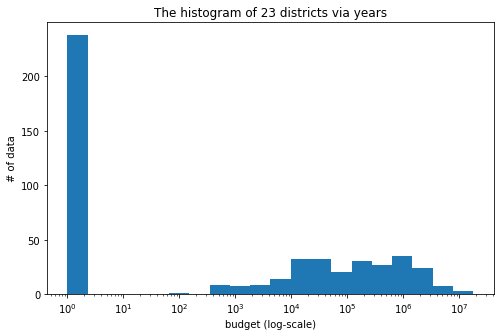

In [ ]:
_, bins, _ = plt.hist(budget_np+1, bins=20)
plt.close()
plt.figure(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(budget_np+1, bins=logbins)
plt.xscale("log")
plt.xlabel("budget (log-scale)")
plt.ylabel("# of data")
plt.title("The histogram of 23 districts via years")
plt.show()

In [ ]:
print(np.sum(budget_np<1e4))
print(np.sum((budget_np>1e4) * (budget_np<1e5)))
print(np.sum((budget_np>1e5) * (budget_np<1e6)))
print(np.sum(budget_np>1e6))

276
78
82
48


# AWS 데이터 (년 단위)
- 1997 ~ 2021
- 지역구가 일반적인 서울시 지역구와 다름 -> 전처리 필요
- 동작구, 종로구 정보가 없음
- 잉여 정보: 기상청, 남현, 북악산, 북한산, 한강, 현충원

In [ ]:
for i, key in enumerate(district_dict.keys()):
  district_dict[key] = i
district_dict

AttributeError: ignored

In [ ]:
district_set & c

In [ ]:
district_set - c

{'동작구', '종로구'}

In [ ]:
c - district_set

{'기상청구', '남현구', '북악산구', '북한산구', '한강구', '현충원구'}

In [ ]:
b = set(df_raw["지점명"])

c = []
for dist in b:
  if not dist[-1]=="구":
    dist = dist.strip() + "구"
  c.append(dist)
c = set(c)
c

In [6]:
df_raw = pd.read_csv("aws_edit/df_train_aws.csv")
df_raw = df_raw.dropna().drop(columns=["Unnamed: 0"]).reset_index(drop=True)
df_raw

,지점명,일시,일강수량_sum_mm,일강수량_mean_mm,일강수량_std_mm,일강수량_max_mm,평균기온_mean_c,평균풍속_mean_ms,최저기온_min_c,최고기온_max_c,최대순간풍속_max_ms,최대순간풍속향_max_deg,집중호우일수
0,강남,2017,995.5,10.820652,26.293209,129.0,25.828261,1.577174,14.6,37.2,19.1,351.6,5.0
1,강남,2018,523.0,5.684783,17.067693,98.0,27.096739,1.518478,17.4,40.0,9.9,340.3,2.0
2,강남,2019,579.0,6.433333,17.185570,115.5,25.817778,1.138889,13.9,37.7,10.4,343.1,1.0
3,강남,2020,1145.5,12.451087,24.334218,101.5,25.422826,1.225275,14.8,36.2,12.3,357.2,4.0
4,강남,2021,428.5,4.657609,14.616702,104.5,26.202174,1.104348,13.6,37.9,11.5,348.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,영등포,2002,851.0,9.250000,27.442197,164.0,24.965934,2.234066,16.0,36.8,16.2,356.9,3.0
648,영등포,2003,1032.0,11.217391,25.730888,160.5,24.378889,1.738462,16.0,33.0,12.6,355.9,3.0
649,영등포,2004,752.5,8.179348,18.940999,100.5,25.865217,1.823913,16.1,38.0,13.3,332.7,2.0
650,영등포,2005,683.0,7.423913,18.566177,124.5,25.852747,1.792308,15.7,38.2,13.9,321.5,2.0


In [ ]:
df_raw[df_raw["지점명"].str.contains("강남")]

# 지역구 면적

In [8]:
df_raw = pd.read_excel("raw_data/지역구면적.xlsx", usecols=["시군구", "합 계"], skiprows=[1,2])
df_raw = df_raw[:26]
df_raw.rename(columns = {"시군구": "지역구"}, inplace=True)

df_raw

,지역구,합 계
0,소계,605.228541
1,종로구,23.913168
2,중구,9.960304
3,용산구,21.866144
4,성동구,16.861004
5,광진구,17.062939
6,동대문구,14.215623
7,중랑구,18.496082
8,성북구,24.576833
9,강북구,23.600355


# 지역구 산림 면적

In [7]:
df_raw = pd.read_excel("raw_data/산림면적(소유별)(1996_2010,+2015).xlsx", sheet_name="데이터", usecols=["자치구별(2)", "소유별(1)", "2015"])
df_raw = df_raw[df_raw["소유별(1)"]=="합계"].drop(columns=["소유별(1)"]).reset_index(drop=True)
df_raw.rename(columns = {"자치구별(2)": "지역구"}, inplace=True)
df_raw

,지역구,2015
0,소계,15486.0
1,종로구,956.0
2,중구,150.0
3,용산구,180.0
4,성동구,55.0
5,광진구,295.0
6,동대문구,120.0
7,중랑구,532.0
8,성북구,936.0
9,강북구,1290.0


# 지역구 하천 개수

In [9]:
df_raw = pd.read_csv("raw_data/서울시 하천개황 정보.csv", encoding="cp949", usecols=["하천명", "종점명"])

for i, line in enumerate(df_raw["종점명"]):
  for word in line.split():
    if word in district_set:
      df_raw.loc[i,"지역구"] = word

df_raw = df_raw.dropna().drop(columns=["종점명"]).reset_index(drop=True)

df_raw

,하천명,지역구
0,양재천,강남구
1,여의천,서초구
2,고덕천,강동구
3,성내천,송파구
4,대사골천,강동구
5,감이천,송파구
6,도림2지류,관악구
7,탄천,송파구
8,목감천,구로구
9,세곡천,서초구


In [10]:
for district in district_list:
  print(district, np.sum(df_raw["지역구"].str.contains(district)))

강남구 1
강동구 3
강북구 3
강서구 0
관악구 2
광진구 0
구로구 2
금천구 1
노원구 3
도봉구 3
동대문구 2
마포구 2
서대문구 1
서초구 2
성동구 3
성북구 1
송파구 3
양천구 0
영등포구 3
용산구 0
은평구 2
중구 0
중랑구 2


# 지역구 맨홀/빗물받이 개수

In [11]:
df_raw = pd.read_excel("data.xlsx", skiprows=[1]).reset_index(drop=True)
df_raw

,지역구,맨홀 (개소),빗물받이 (개소)
0,종로구,9843,16183
1,중구,8049,15020
2,용산구,9676,17917
3,성동구,8403,15726
4,광진구,9926,25024
5,동대문구,11989,21593
6,중랑구,12106,18496
7,성북구,14595,22957
8,강북구,10780,16494
9,도봉구,8842,12137


In [ ]:
df_social = pd.read_excel("data.xlsx", skiprows=[1]).reset_index(drop=True)
df_social[df_social["지역구"].str.contains(district)].squeeze().to_string(header=False, index=False).split("\n")


['  중랑구', '12106', '18496']